In [1]:
from urllib import request
import pandas as pd
import zipfile
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook
import tqdm
import copy

from torch.optim import SGD,Adam
from torch.nn import MSELoss
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [2]:
DATASET_URL = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
DATASET_ARCHIVE = 'ml-100k.zip'

request.urlretrieve(DATASET_URL, DATASET_ARCHIVE)
with zipfile.ZipFile(DATASET_ARCHIVE) as archive:
    archive.extractall()

### Task 1

1. Go over the NCF paper (https://arxiv.org/abs/1708.05031) to understand the architecture of the model
2. Implement NCF class. In particular:  
    a. implement __init__ to create the model achtecture  
    b. initialisation is already implemented for you  
    c. implement forward. Forward should take u_id and i_id and return the propability of consumption given u_id and i_id (what is the output layer?)
    d. Test your forward by providing some random u_id and i_id

In [3]:
class NeuMF(nn.Module):
    def __init__(self, nb_users, nb_items,
                 mf_dim, mlp_layer_sizes, dropout=0):
        
        if mlp_layer_sizes[0] % 2 != 0:
            raise RuntimeError('u dummy, mlp_layer_sizes[0] % 2 != 0')
        super(NeuMF, self).__init__()
        nb_mlp_layers = len(mlp_layer_sizes)
        #YOUR TASK: ADD EMBEEDING LAYERS TO THE MODEL - be careful with sizes ~5 lines of code
        self.mf_user_embed = nn.Embedding(nb_users, mf_dim)
        self.mf_item_embed = nn.Embedding(nb_items, mf_dim)
        self.mlp_user_embed = nn.Embedding(nb_users, mlp_layer_sizes[0] // 2)
        self.mlp_item_embed = nn.Embedding(nb_items, mlp_layer_sizes[0] // 2)
        self.dropout = dropout
        #YOUR TASK: ADD MLPs and the final layer ~4-6 lines of code
        self.mlp = nn.ModuleList()
        for i in range(1, nb_mlp_layers):
            self.mlp.extend([nn.Linear(mlp_layer_sizes[i - 1], mlp_layer_sizes[i])])  
        self.final = nn.Linear(mlp_layer_sizes[-1] + mf_dim, 1)
        #YOUR TASK: Initialze weights ~4 lines of code - use glorot
        self.mf_user_embed.weight.data.normal_(0., 0.01)
        self.mf_item_embed.weight.data.normal_(0., 0.01)
        self.mlp_user_embed.weight.data.normal_(0., 0.01)
        self.mlp_item_embed.weight.data.normal_(0., 0.01)
        def glorot_uniform(layer):
            fan_in, fan_out = layer.in_features, layer.out_features
            limit = np.sqrt(6. / (fan_in + fan_out))
            layer.weight.data.uniform_(-limit, limit)

        def lecunn_uniform(layer):
            fan_in, fan_out = layer.in_features, layer.out_features  # noqa: F841, E501
            limit = np.sqrt(3. / fan_in)
            layer.weight.data.uniform_(-limit, limit)
        for layer in self.mlp:
            if type(layer) != nn.Linear:
                continue
            glorot_uniform(layer)
        lecunn_uniform(self.final)

    def forward(self, user, item, sigmoid=False):
        #YOUR TASK: Implement model forward. ~15 lines of code
        xmfu = self.mf_user_embed(user)
        xmfi = self.mf_item_embed(item)
        xmf = xmfu * xmfi

        xmlpu = self.mlp_user_embed(user)
        xmlpi = self.mlp_item_embed(item)
        xmlp = torch.cat((xmlpu, xmlpi), dim=1)
        for i, layer in enumerate(self.mlp):
            xmlp = layer(xmlp)
            xmlp = nn.functional.relu(xmlp)
            if self.dropout != 0:
                xmlp = nn.functional.dropout(xmlp, p=self.dropout, training=self.training)

        x = torch.cat((xmf, xmlp), dim=1)
        x = self.final(x)
        if sigmoid:
            x = torch.sigmoid(x)
        return x

### Task 2

1. Implement ML100kDataset. In particular:  
    a. implement all needed functions that overload PyTorch Dataset
    b. Implement negaive sampling. This can be approximated negative sampling negative_samples=n means that if user A has m training points (positive) it will have n*m negive points

In [4]:
class ML100kDataset(Dataset):
    def __init__(self,file_name,negative_samples=1):
        ratings_df=pd.read_csv(file_name, header=None, names=['user_id', 'item_id', 'rating', 'timestamp'],delim_whitespace=True)
        max_item = np.max(ratings_df['item_id'])
        ratings_df.drop(['rating','timestamp'],axis=1,inplace=True)
        ratings = torch.from_numpy(ratings_df.values)         
        self.negative_samples = negative_samples
        self.raw_dataset_length = len(ratings_df.index) 
        self.length_after_augmentation = self.raw_dataset_length * (self.negative_samples + 1)
        #YOUR TASK: Implement negative sampling. ~7 lines of code. NOTE: the dataset does not have to be shuffled, but you can do this!
        #Sample neg users
        USER,ITEM=0,1
        neg_users = ratings[:,USER].repeat(self.negative_samples)
        self.users = torch.cat((ratings[:,USER], neg_users))
        #sample neg items
        neg_items = torch.empty_like(ratings[:,ITEM]).repeat(self.negative_samples).random_(0,max_item)
        self.items = torch.cat((ratings[:,ITEM], neg_items))
        #labels
        neg_label = torch.zeros_like(ratings[:,ITEM], dtype=torch.float32).repeat(self.negative_samples)
        self.labels = torch.cat((torch.ones_like(ratings[:,ITEM], dtype=torch.float32), neg_label))

    def __len__(self):
        return self.length_after_augmentation
  
    def __getitem__(self,idx):
        return self.users[idx],self.items[idx],self.labels[idx]

### Task 3

1. Implement training loop. In particular:  
    a. Every epoch you make log average train loss and test/eval loss  
    b. use different loss/optimiser/other HP. Use dependency injection to play with them.  
    c. Find "best" HP during cross-validation.  
    d. Check when model overfits with learning curves.  
    e. What are the conclusions.  
    f*. You can user HR@n from previous excersise to look for overfitting.  
    g*. Check the influence of shuffling on your results

In [5]:
def HR_at_n(R,R_hat,R_exclude,n=10):
    R_hat = copy.copy(R_hat)
    exclude_items_per_user = np.sum(R_exclude>0,axis=1)
    R_hat[R_exclude>0] = -np.inf
    pred_items = np.argsort(-R_hat,axis=1)
    true_items = np.argsort(-R,axis=1)
    exclude_items_cnt = np.sum(R_exclude>0,axis=1)
    test_items_cnt = np.sum(R>0,axis=1)
    hr_total = 0
    for user_id in range(pred_items.shape[0]):
        min_end = min(n,pred_items.shape[1]-exclude_items_cnt[user_id])
        pred_items_for_user = pred_items[user_id,:min_end]
        propper_itemscnt_for_user = np.sum(np.in1d(pred_items_for_user, true_items[user_id,:test_items_cnt[user_id]]))
        if test_items_cnt[user_id]>0:
            hr_for_user = propper_itemscnt_for_user/min(n,test_items_cnt[user_id])
            hr_total += hr_for_user
    
    hr_total/=np.shape(R)[0]
    
    return hr_total

In [26]:
#HYPERPARAMETER TUNING:

learning_rates = [0.01, 0.001, 0.0001]
dropout = [0.2, 0.5, 0.7]
mf_dim = [8, 16]
#mlp_layer_sizes = [[64, 32],[128,64,32], [128, 64]]

best_loss=float('inf')
best_params={
    'learning_rates':0,
    'dropout':0,
    'mf_dim':0
}

users_num = 943 + 1
movies_num = 1682 + 1

ds = ML100kDataset('ml-100k/u.data', 2)
k = KFold(n_splits=3, shuffle=True) # I reduced number of folds to minimize runtime
#ds_train = ML100kDataset('ml-100k/u1.base',2)
#ds_test = ML100kDataset('ml-100k/u1.test',2)
# create a data loader for train and test sets

for l_r in learning_rates:
    for drop in dropout:
        for dim in mf_dim:

            # CROSS-VALIDATION:
            fold_loss=[]
            for train_id, test_id in k.split(ds):

                train_ds = torch.utils.data.Subset(ds, train_id)
                test_ds = torch.utils.data.Subset(ds, test_id)
                train_dl = DataLoader(ds_train, batch_size=16*1024,shuffle=True)
                test_dl = DataLoader(ds_test, batch_size=16*1024, shuffle=False)

                model = NeuMF(users_num,movies_num,dim,[128,64,32],drop)
                criterion = nn.BCELoss()
                optimizer = Adam(model.parameters(), lr=l_r)
                test_loss = []
                train_loss = []

                for epoch in range(4): # I reduced number of epochs to minimize runtime
                    model.train()
                    tr_loss=[]
                    print("Traininng "+str(epoch))
                    for (u,i,l) in tqdm.tqdm(train_dl):
                        # clear the gradients
                        optimizer.zero_grad()
                        # compute the model output
                        yhat = model(u,i,sigmoid=True)
                        l = l.unsqueeze(1)
                        # calculate loss
                        loss = criterion(yhat, l)
                        tr_loss.append(loss.detach().numpy())
                        # credit assignment
                        loss.backward()
                        # update model weights
                        optimizer.step()
                    train_loss.append(np.mean(tr_loss))
                    model.eval()
                    predictions = []
                    with torch.no_grad():
                        t_loss=[]
                        for i, (u,i,l) in enumerate(test_dl):
                            yhat = model(u, i, sigmoid=True)
                            predictions.append(yhat)
                            l = l.unsqueeze(1)
                            tl = criterion(yhat, l)
                            t_loss.append(tl) 
                        test_loss.append(np.mean(t_loss))


            fold_loss.append(test_loss[-1])
            avg_fold_loss = np.mean(fold_loss)

            if avg_fold_loss < best_loss:
                best_loss = avg_fold_loss
                best_params['learning_rates']=l_r
                best_params['dropout']=drop
                best_params['mf_dim']=dim

print('Best parameters: ', best_params)

Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.98it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.10it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.12it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.21it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.09it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.01it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.06it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.02it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.99it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:04<00:00,  3.02it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.97it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.94it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.93it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.93it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.88it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.87it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.87it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.93it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.90it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.88it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.86it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.91it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.95it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.86it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.91it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.85it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.93it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.89it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.94it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.86it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.85it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.87it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.85it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.85it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.84it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.81it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.89it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.91it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.87it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.88it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.82it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.87it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.88it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.82it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.89it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.86it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.84it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.90it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.84it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.94it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.87it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.84it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.81it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.93it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.84it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.95it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.81it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.85it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.85it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.79it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:06<00:00,  2.47it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.78it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.79it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.74it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.85it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.73it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.65it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.88it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.90it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.91it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.89it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.82it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.85it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.89it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.83it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.85it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.81it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.84it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.81it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.82it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.82it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.53it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.86it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.85it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.81it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.84it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.86it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.88it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.82it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.83it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.82it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.81it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.86it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.80it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.79it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.83it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.83it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.83it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.88it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.81it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.86it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.78it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.88it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.77it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.84it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.58it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.75it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.53it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.75it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.85it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.82it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.78it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.84it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.81it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.83it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.80it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.80it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.83it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.84it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.87it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.85it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.87it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.86it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.85it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.75it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.88it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.77it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.83it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.78it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.85it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.84it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.89it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.79it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.85it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.81it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.83it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.83it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.81it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.80it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.82it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.75it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.80it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.84it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.78it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.87it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.77it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.80it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.86it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.83it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.82it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.86it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.90it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.84it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.81it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.83it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.80it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.84it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.81it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.84it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.86it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.83it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.84it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.85it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.79it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.84it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.80it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.87it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.79it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.82it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.80it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.87it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.77it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.83it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.78it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.85it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.89it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.86it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.89it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.83it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.85it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.79it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.76it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.79it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.79it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.81it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.85it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.80it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.82it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.78it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.83it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.81it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.79it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.86it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.86it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.81it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.79it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.86it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.84it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.82it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.82it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.83it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.78it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.74it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.53it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.59it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.80it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.81it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.77it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.76it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.84it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.82it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.78it/s]


Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.84it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.82it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.84it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.80it/s]


Best parameters:  {'learning_rates': 0.01, 'dropout': 0.2, 'mf_dim': 16}


### Your task
1. Find best HP of the model by crossvalidation
2. for every user provide the recommendation, calculate HR@10 (as in the previous excersise)

In [55]:
# BEST PARAMETERS: learning rate = 0.01, dropout = 0.2, mf_dim = 16
train_loss=[]
test_loss=[]

train_HRs=[]
test_HRs=[]

users_num = 943 + 1
movies_num = 1682 + 1

ds_train = ML100kDataset('ml-100k/u1.base',2)
ds_test = ML100kDataset('ml-100k/u1.test',2)
# create a data loader for train and test sets

train_dl = DataLoader(ds_train, batch_size=16*1024,shuffle=True)
test_dl = DataLoader(ds_test, batch_size=16*1024, shuffle=False)

model = NeuMF(users_num,movies_num,best_params['mf_dim'],[128,64,32],best_params['dropout'])
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=best_params['learning_rates'])

for epoch in range(8): # reduced number of epoch to minimize runtime
    model.train()
    tr_loss=[]
    hrs1=[]
    print("Traininng "+str(epoch))
    for (u,i,l) in tqdm.tqdm(train_dl):
        # clear the gradients
        optimizer.zero_grad()
        # compute the model output
        yhat = model(u,i,sigmoid=True)
        l = l.unsqueeze(1)
        # calculate loss
        loss = criterion(yhat, l)
        tr_loss.append(loss.detach().numpy())
        # credit assignment
        loss.backward()
        # update model weights
        optimizer.step()
        hr_at_n_train = HR_at_n(np.array(l), yhat.detach().numpy(), np.zeros_like(l), n=10)
        hrs1.append(hr_at_n_train)
    
    train_loss.append(np.mean(tr_loss))
    train_HRs.append(np.mean(hrs1))
    
    model.eval()
    #pred_test = []
    #true_test = []
    hrs2=[]
    with torch.no_grad():
        t_loss=[]
        for i, (u,i,l) in enumerate(test_dl):
            yhat_test = model(u, i, sigmoid=True)
  
            l2 = l.unsqueeze(1)
            tl = criterion(yhat_test, l2)
            t_loss.append(tl)
            
            hr_at_n_test = HR_at_n(np.array(l2), yhat_test, np.zeros_like(l2), n=10)
            hrs2.append(hr_at_n_test)
            
        test_loss.append(np.mean(t_loss))
    
  
        test_HRs.append(np.mean(hrs2))



Traininng 0


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.56it/s]


Traininng 1


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.78it/s]


Traininng 2


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.82it/s]


Traininng 3


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:09<00:00,  1.66it/s]


Traininng 4


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.67it/s]


Traininng 5


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.67it/s]


Traininng 6


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.68it/s]


Traininng 7


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:08<00:00,  1.68it/s]


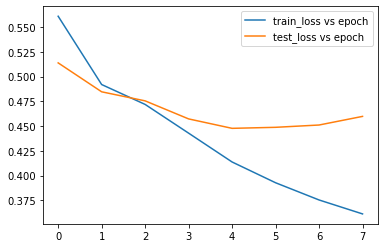

HR@10 for test:  0.0


In [56]:
plt.plot(train_loss,label='train_loss vs epoch')
plt.plot(test_loss,label='test_loss vs epoch')
plt.legend()
plt.show()

print('HR@10 for test: ',hr_at_n_test)

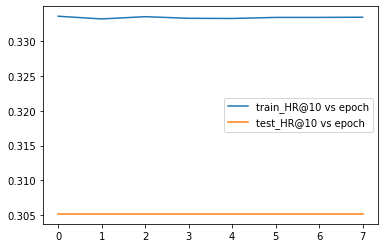

In [57]:
plt.plot(train_HRs,label='train_HR@10 vs epoch')
plt.plot(test_HRs,label='test_HR@10 vs epoch')
plt.legend()
plt.show()